# Noise reduction test 5c: unknown process noise - linear scale - additive noise - multiple inputs - AR(1) - more frequencies

<br></br>

---
---
---
<br></br>

# Load libraries

In [49]:
using ForneyLab       # based on last official release
using LinearAlgebra
using Plots
using ProgressMeter
using Compat
using WAV
using Base64
using FileIO
using HDF5
using FLAC
using DSP
using LAR
using LAR.AR
using FFTW
using PyPlot

include("functions/auxiliary/buffer.jl")
include("functions/auxiliary/audioplayer.jl")
include("functions/auxiliary/workflow.jl")
include("functions/auxiliary/fourier.jl")
;

<br></br>

---
---
---
<br></br>

# Load and process data

In [2]:
# specify desired sampling frequency
fs_desired = 16000

# specify signnal gains
g_speech = 1
g_drill = 1

# load and process drilling sound
x_drill, fs_drill = wavread("data/drilling.wav", format="native")
fs_drill = Int(fs_drill)
x_drill = x_drill[11*fs_drill+1:14*fs_drill]
x_drill = resample(x_drill, fs_desired/fs_drill)
x_drill = 100*x_drill/var(x_drill)

# load and process speech
x_speech, fs_speech = wavread("data/obama.wav", format="native")
fs_speech = Int(fs_speech)
x_speech = x_speech[20*fs_speech+1:23*fs_speech]
x_speech = resample(x_speech, fs_desired/fs_speech)
x_speech = 100*x_speech/var(x_speech)

# specify time axis
t = collect((1:length(x_drill))/fs_desired)

# combine audio signals
x_combined = g_speech*x_speech + g_drill*x_drill

# create plots of {drill, speech, combined}
audioplayers(x_drill, x_speech, x_combined, fs=fs_desired)
;

<source src="data:audio/wav;base64,UklGRjzuAgBXQVZFZm10ICgAAAD+/wEAgD4AAAD6AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQDuAgDYTNG42fvFuGjpGTlHnjk5J8+COWucpznRhZE5tkiFOUtjUDkj7mo5F0UuOe4bDDn2rhA3PfKMudlN0Lk3bve5VZ4Fuo49HbpOeyO6K8EFukddxrnaSrm5VGG0uWFl5bmLyuS5qSWOuX8+v7jeDzM4P8KLt7RTz7eoM3u35nz/uCe56rjzc1y56Vz9uBN58DeZWLI451gpOY0fXzmPafM4lVk2tiWYpTfUibw4fPpoOWCnjjikNY22hhLpOKOb+TcWMS44Hho8tvuCE7hXKCK5MeR0uamlqrmJ8+a5ET7YuRXkfbmTAla5VkT5uGPxKrkxLwi5vKGsuLh9P7ntfhC5F2qbN7ALuDhCqkU5sSStOfMRmjmfaDw5fuWMOaAZjzl3D9M4rzhiuAkfCrlagw65gD2ut8iVCLmcFyy5Ezd5t+GEoDjjHDI4QGFBOAxCqDhriJA58g2+ORX/ADosrfY5o83VOVytlTnt3BU5vpfHOEC+MTdV9Ri5OyGKuftaprg9BcQ3wp5QuIBx87ip5Fm5+QaIuSOL/bh0XzU3Fs6DOKFJUTlYO4g5FWSPORTZYjn5Yyg4UMG6NBSwpLdyoYA4/yiuNkR42Tdrpl+4qEwvucDtG7lZXpm50CfZuQ+g6Lmkur250EMpucY9tDixnpo5oVzVOaf+BTogp/c5ekN3OUdu1zhekBo5jo5YN3FdbbktRYa5vmlbucVVgbn1a5S5dkvyuWQ1Brogwea53ibnuSwdxbnG0Pa51KnruRbri7mHQRq5l2EwuSvfXbkNrk65okEnuHpeJDnZGxQ6QlEPOgdk0TmRODs5srLst7DsQTeg3UC3gToOueHUd7kNofG4vLg8OZZl9TlNsMA52A5VOSc/ZznkhpM5RvPWOeizCzoUgxA6nCPAOeSzgzmbEzE5EYKnuP+darmg8NG5I8TvubrR/LlPcsy5nkQPupy2MLqMdRG6wmlguQO0QzjoBpU4BdOhOJAxWznjmcQ5CQ0hOqoQaDoshIg6SN1wOlRZVTocej46zoI+OtGULTqCHQ06ZjCyOauRlzhPMsI4JLOgOG0E2jcJXNC4rs3YuM3eZrh7Ceo4dXkkOWuvjjiExpi2bBsYtjmnpzc+5ia5BKCpuXsR67nlXFC5MuwhuI1RH7kB2+65FAgKuuR117kjaEi5fNFfuTb1trniOSS6xYIour5oobn/4ya5m5GWuBJS9LjJAkk4MJrONV7lWDjp2iM5Y0xeOa11DrmyjY252IeHudBobrkubqG5cbo1unZ6a7otfl+6nRg7uowhU7rDNGG6IcQ1ulO4xrkVqYy5Z2WpuCf+rbj/LmS5gE7TuCrhCDhJ67w4A2zPNbZPR7m6F1G5htkcuQzBk7dU2ik538DkObZLsjk6GP44ezlUOaDKrTnYF205SyYoOdEbGzkYv+g5H/s0Ol+LIDpsKvI5bhy9ObmbkDmrL4I418cxuG5SgriXhGI4GncEOb0tYTk8g1I5aRKXOe/jbzn34Kg4XDIuOUyunznzKIQ5fWrsOFeBnznn49o5xqW0OXkNkDmSaUQ5XfiCuP7VrbmMvMm5FClVubdgLrnpCF65s62Mudq2P7lTYCq4k66wM6bbKbjrWbe38VIZOY9CFjkATGc2zVpVOUpGADoeXd05Ms5QOci5FDmgTkE4F9HaN6tfEznNweU5llAUOhmFAjr1NI0550d4OMJXhLcVoj+4NTOSOFkkazm5SIU5/zCJOYq3sjm6lwk6jFO9Odp517hTqDS5t9jWuX9JBLqiHVW6NEyPuoaMSLqqJfa56PQ+upS0bboMPkO6QlrPubfTiblAWLG430HTOGhlgTml71g4qOnruM2yRDabvvk4kwicOS3gOTlgrw850LV2OSlgzTm8tgI69qfMOZpniTl9qZw5PGrhOU4I8jnRDgU65iMcOrhS2zll5Nk5ylMbOiTm3jlnGpk5KhM/OTHyVbehnJm5GA7tucD5Arq/nNO5J0TAuWmB0bnEq4W5gyMXuX77JLmOITQ5a7iGOQEgYTkPR8M5O80mOq9jdjqjJ146+WJXOicEUjpxNWw6yGo9OvKbxTnH9AU5JANgOd8tJzmO+0Q4PzfcuXxEMbq8el26R76RuusrjbqTe3S6u6qAumLvibquqWW62hlauvm3WLqBtVe6EMIouqjc4Ll1FxW6RLlluhnHVLpmtSy6Otfuuez1xrmTA6S5Vpypt0j4PTl0Pd44M+SsOPhsnjnVMC06I/seOutA6zlx6/0511TdOUiusTms6NY4ADywuM4ejrlFSUC58+xUtzjjszhJZX84VxEYOXZ3Zrizlka4ZramNryf/LU8myG5MysluWhxGLjGMcq4copbN4fMdDjYGvY2CT+VuWXCKbliQJO4GlsBNqPaiTnrztc5E3UXOhNwdjr0o0Y68ZwmOo2hQjqMgEs62nsuOlkqZDosGWQ69JQjOvxNCzqyDcY5QlHEOV7FrjlO6u84mO6JOP0w5zfnbYW54xOauVKH6rgtkT+5RHHmudbDDbpgjCi6eXIyuo09GbpiCMy5EOh2uYKr1zhe3Yw5EYibOT82kjmeVZM5XQtAOe4ONjmF0Ls4bMNNNkuZDDnyLUG2/GDuuDa1grmvyu25hcEfunOVOLqk0Fu6fUVuujGDP7ro7qa5x+cVuXvIg7mHChq6YNJJupQtNbqKEOG5j0OGuSOs+jdzk2k5qcWMOY2PkzndDIE51yrEOau5pTmkz+o5tnMJOgKmDzrLn8I5CpU9OZI6eTioczk4gWlyuQ4QObpuewm6oxK9ueKRw7ldTfS5+PqIuZp6F7n477e5B4kjusKMDbrRZZa598xcuU/oJbpUpV+6ZMYquv90y7kzOrG5pVbQuZOSoLmFSaW5hqORuWCOnrk33Ne2ZEaBOQfttDnSIQ06jBBUOmWARTrmOy0612jxOV6YQzlzaco43WoYOc8IBTm+0xs5Wxm7OGiiFrmIxwO6uh76uV36Mrm3aI+4p0ehOAnHwTmFMgw6sq3qORXkjjmkQpY58bBCOY3ogjkms605KLWMOdVL9zlQigg60ZEwOqXZKzrKrBU6Jty8Ocu0Jzml13g5mEFdObGWGjmnzAo5Mq+SOeC6jzdAxxK5S4iDNpn3EjnGlPc4XyKlMTG6zjgGeiy4M61OuSGaBLmes7i3lba1OIrC5bhphZa4SPbnuOHHHjYXRrA4Ym6IuXvF07lyHua53dmxuf5EyLlHN9a55NgcuseTCbrduOa5QGXeucxF47n3AKm5NB6duH1yQDkfmCA6dW1QOpnpbTo6IS86zBY0Ohut9znV/oU5EhCgOaFuxDlsJ+I5BX+DOccFnrgNAOa4P8DHN8CeAblvKXy5qlHdudi1Abp4ki26nPQlulbtR7oF+jm6tOLyuaNgNbmNPOS5KWQbuuyX77kijY25nZAEuWMFy7jQjqY28vWDOeOt4zn7Dxo6SFsoOts2VzoIR2M6vrhtOu+gWDoZ/Wk6TTBsOm15UzqWKSw6jKDuOSZ+vTmF0MU5D9ZuOfo/njk+eq05x2JGOSIPODlWchU3asIfuTF3v7lFVPq593eQuUbtQ7kgt9u5JWIdugd9/rnu2ua5ziukuU2iV7ntqPG4xy+Dt1qWtLjO+aC4M/TLuPC8W7nO8YK5idSEuf1Ojbm2Xp+5o/bpuULYHLq2lUO6AL9Dukf0M7omGje6uWYgugp/FbpZ6a+58BqquCMXg7bch8G3CUkCN2anhzhv2Y04HUmoOTaKCDroPSs6fx8xOtgbKzoTbhI6UHG6OfxcwjmTnAo5rxY/OduafzgT6+K3QG+FuaQds7l4gMq4EUBjORKkNziK8pK5VzCwuQZgiLmFMcW4FEu/Nnm2DzrId

<br></br>

---
---
---
<br></br>

# Learning drilling parameters

## Settings

In [3]:
# specify frequency spacing
#fc = convert(Array{Float64}, [60, 150, 250, 350, 450, 570, 700, 840, 1000, 1170, 1370, 1600, 1850, 2150, 2500, 2900, 3400, 4000, 4800, 5800, 7000])
fc = convert(Array{Float64}, collect(0:200:8000))
# amount of frequency components (DC, real and imaginary)
nr_components = 2*length(fc) + 1

# specify AR order of frequency components
ARorder = 1

# specify auxiliary variables and initialize buffer
nr_samples = length(x_drill)
nr_iterations = 5
buf_size = 10
step_size = 10
nr_steps = Int((nr_samples - buf_size)/step_size)
;

---

## Create Factor Graph

In [4]:
# create factor graphs
fg = FactorGraph()

# define vector containing all current spectral estimatess
@RV s

# create vectors for storing spectral component models
si = Vector{Variable}(undef, nr_components)     
γi = Vector{Variable}(undef, nr_components)
wi = Vector{Variable}(undef, nr_components)
θi = Vector{Variable}(undef, nr_components)
Si_prev = Vector{Variable}(undef, nr_components)
Si = Vector{Variable}(undef, nr_components)

# specify models of spectral components
for i = 1:nr_components
    
    # specify selection matrix
    d = zeros(nr_components)
    d[i] = 1
    
    # specify selected component
    @RV [id=pad(:si, i)] si[i] ~ DotProduct(d,
                                            s)
    
    # specify unknown precision of process noise
    @RV [id=pad(:γi, i)] γi[i] ~ ForneyLab.Gamma(placeholder(pad(:a_γi, i)), 
                                                 placeholder(pad(:b_γi, i)))
    
    # declare priors as random variables
    @RV [id=pad(:θi, i)] θi[i] ~ GaussianMeanPrecision(placeholder(pad(:μ_θi, i), dims=(ARorder,)),
                                                       placeholder(pad(:Λ_θi, i), dims=(ARorder, ARorder)))

    # specify previous states of S
    @RV [id=pad(:Si_prev, i)] Si_prev[i] ~ GaussianMeanPrecision(placeholder(pad(:μ_Si_prev, i), dims=(ARorder,)),
                                                                 placeholder(pad(:Λ_Si_prev, i), dims=(ARorder, ARorder)))
    
    # specify spectral model (FIXED precision)
    @RV [id=pad(:Si, i)] Si[i] ~ LAR.AR.Autoregressive(θi[i], 
                                                       Si_prev[i], 
                                                       γi[i])
    
    # link spectral models to Fourier transform
    z = zeros(ARorder)
    z[1] = 1
    DotProduct(si[i],
               Si[i],
               z)
end

# specify signal
@RV x ~ DotProduct(placeholder(:c, dims=(nr_components,buf_size)),
                   s)

# specify measurement noise (almost none)
@RV v ~ GaussianMeanPrecision(zeros(buf_size),
                              100*I(buf_size))

# specify observed variable
@RV y ~ Addition(x, v)

# create placeholder for observed variable
placeholder(y, :y, dims=(buf_size,))

draw(fg, external_viewer=:default)
;

---

## Define recognition factorizations

In [5]:
# create memory vector for recognition factorizations of frequency components
q_AR = Vector{RecognitionFactorization}(undef, nr_components)

# loop through frequency components
for i = 1:nr_components
    
    # specify recognition factorization for frequency component
    q_ids = [pad(:q_θi, i), 
             pad(:q_Si, i),
             pad(:q_Si_prev, i),
             pad(:q_γi, i),
             :x]
    q_AR[i] = RecognitionFactorization(θi[i], Si[i], Si_prev[i], γi[i], x, ids=q_ids)
end
;

---

## Construct algorithms

In [6]:
# create memory vector for algorithms of frequency components
algo_AR = Vector{String}(undef, nr_components)

# create algorithms for frequency components
for i = 1:nr_components
    algo_AR[i] = compatibility_fix(variationalAlgorithm(q_AR[i]))
end
;

In [7]:
# Load algorithms
for i = 1:nr_components
    eval(Meta.parse(algo_AR[i]))
end
steps_Si_prev = names(Main)[findall(x -> occursin("stepq_Si_prev", String(x)), names(Main))]
steps_Si = names(Main)[findall(x -> occursin("stepq_Si", String(x)) & !(x in steps_Si_prev), names(Main))]
steps_θi = names(Main)[findall(x -> occursin("stepq_θi", String(x)), names(Main))]
steps_γi = names(Main)[findall(x -> occursin("stepq_γi", String(x)), names(Main))]
steps_x = names(Main)[findall(x -> occursin("stepx", String(x)), names(Main))]
;

---

## Specify priors

In [8]:
# create memory vectors for priors over frequency components
current_μ_Si_prev = Vector{Array{Float64,1}}(undef, nr_components)
current_Λ_Si_prev = Vector{Array{Float64,2}}(undef, nr_components)
current_a_γi = Vector{Float64}(undef, nr_components)
current_b_γi = Vector{Float64}(undef, nr_components)
current_μ_θi = Vector{Array{Float64,1}}(undef, nr_components)
current_Λ_θi = Vector{Array{Float64,2}}(undef, nr_components)


# specify priors over frequency components
for i = 1:nr_components
    current_μ_Si_prev[i] = zeros(ARorder)
    current_Λ_Si_prev[i] = tiny*collect(I(ARorder))
    current_a_γi[i] = 0.01
    current_b_γi[i] = 0.01
    current_μ_θi[i] = zeros(ARorder)
    current_Λ_θi[i] = tiny*collect(I(ARorder))
end

---

## Create memory vectors

In [9]:
total_a_γi = Vector{Vector{Float64}}(undef, nr_steps)
total_b_γi = Vector{Vector{Float64}}(undef, nr_steps)
total_μ_Si = Vector{Vector{Array{Float64,1}}}(undef, nr_steps)
total_Λ_Si = Vector{Vector{Array{Float64,2}}}(undef, nr_steps)
total_μ_θi = Vector{Vector{Array{Float64,1}}}(undef, nr_steps)
total_Λ_θi = Vector{Vector{Array{Float64,2}}}(undef, nr_steps)
total_μ_x = Vector{Array{Float64,1}}(undef, nr_steps)
total_Λ_x = Vector{Array{Float64,2}}(undef, nr_steps)
total_x = Vector{Array{Float64,1}}(undef, nr_steps)
total_s = Vector{Vector{Float64}}(undef, nr_steps)

for i = 1:nr_steps
    total_a_γi[i] = Vector{Float64}(undef, nr_components)
    total_b_γi[i] = Vector{Float64}(undef, nr_components)
    total_μ_Si[i] = Vector{Array{Float64,1}}(undef, nr_components)
    total_Λ_Si[i] = Vector{Array{Float64,2}}(undef, nr_components)
    total_μ_θi[i] = Vector{Array{Float64,1}}(undef, nr_components)
    total_Λ_θi[i] = Vector{Array{Float64,2}}(undef, nr_components)
end

predictions = []
;

---

## Create marginals and data buffer

In [10]:
# create marginals dictionary
marginals = Dict{Symbol, ProbabilityDistribution}()
marginals[:x] = ProbabilityDistribution(ForneyLab.Univariate, GaussianMeanPrecision, m=0, w=1e-4)
for i = 1:nr_components
    marginals[pad(:γi, i)] = ProbabilityDistribution(ForneyLab.Univariate, ForneyLab.Gamma, a=current_a_γi[i], b=current_b_γi[i])
    marginals[pad(:θi, i)] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanPrecision, m=current_μ_θi[i], w=current_Λ_θi[i])
    marginals[pad(:Si_prev, i)] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanPrecision, m=current_μ_Si_prev[i], w=current_Λ_Si_prev[i])
end

# create data buffer
buf = BufferData(x_drill, t, buf_size)
FLAG_data_remaining = true
;

---

## Calculate downward message on x

In [11]:
function predictx(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 400))

messages[1] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_83], marginals[:θi_83], marginals[:γi_83])
messages[2] = ruleSPDotProductOutNGP(nothing, messages[1], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[3] = ruleSPDotProductIn2GPN(messages[2], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]), nothing)
messages[4] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_82], marginals[:θi_82], marginals[:γi_82])
messages[5] = ruleSPDotProductOutNGP(nothing, messages[4], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[6] = ruleSPDotProductIn2GPN(messages[5], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]), nothing)
messages[7] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_81], marginals[:θi_81], marginals[:γi_81])
messages[8] = ruleSPDotProductOutNGP(nothing, messages[7], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[9] = ruleSPDotProductIn2GPN(messages[8], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]), nothing)
messages[10] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_80], marginals[:θi_80], marginals[:γi_80])
messages[11] = ruleSPDotProductOutNGP(nothing, messages[10], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[12] = ruleSPDotProductIn2GPN(messages[11], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]), nothing)
messages[13] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_79], marginals[:θi_79], marginals[:γi_79])
messages[14] = ruleSPDotProductOutNGP(nothing, messages[13], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[15] = ruleSPDotProductIn2GPN(messages[14], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[16] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_78], marginals[:θi_78], marginals[:γi_78])
messages[17] = ruleSPDotProductOutNGP(nothing, messages[16], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[18] = ruleSPDotProductIn2GPN(messages[17], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[19] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_77], marginals[:θi_77], marginals[:γi_77])
messages[20] = ruleSPDotProductOutNGP(nothing, messages[19], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[21] = ruleSPDotProductIn2GPN(messages[20], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[22] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_76], marginals[:θi_76], marginals[:γi_76])
messages[23] = ruleSPDotProductOutNGP(nothing, messages[22], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[24] = ruleSPDotProductIn2GPN(messages[23], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[25] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_75], marginals[:θi_75], marginals[:γi_75])
messages[26] = ruleSPDotProductOutNGP(nothing, messages[25], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[27] = ruleSPDotProductIn2GPN(messages[26], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[28] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_74], marginals[:θi_74], marginals[:γi_74])
messages[29] = ruleSPDotProductOutNGP(nothing, messages[28], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[30] = ruleSPDotProductIn2GPN(messages[29], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[31] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_73], marginals[:θi_73], marginals[:γi_73])
messages[32] = ruleSPDotProductOutNGP(nothing, messages[31], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[33] = ruleSPDotProductIn2GPN(messages[32], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[34] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_72], marginals[:θi_72], marginals[:γi_72])
messages[35] = ruleSPDotProductOutNGP(nothing, messages[34], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[36] = ruleSPDotProductIn2GPN(messages[35], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[37] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_71], marginals[:θi_71], marginals[:γi_71])
messages[38] = ruleSPDotProductOutNGP(nothing, messages[37], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[39] = ruleSPDotProductIn2GPN(messages[38], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[40] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_70], marginals[:θi_70], marginals[:γi_70])
messages[41] = ruleSPDotProductOutNGP(nothing, messages[40], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[42] = ruleSPDotProductIn2GPN(messages[41], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[43] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_69], marginals[:θi_69], marginals[:γi_69])
messages[44] = ruleSPDotProductOutNGP(nothing, messages[43], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[45] = ruleSPDotProductIn2GPN(messages[44], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[46] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_68], marginals[:θi_68], marginals[:γi_68])
messages[47] = ruleSPDotProductOutNGP(nothing, messages[46], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[48] = ruleSPDotProductIn2GPN(messages[47], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[49] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_67], marginals[:θi_67], marginals[:γi_67])
messages[50] = ruleSPDotProductOutNGP(nothing, messages[49], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[51] = ruleSPDotProductIn2GPN(messages[50], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[52] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_66], marginals[:θi_66], marginals[:γi_66])
messages[53] = ruleSPDotProductOutNGP(nothing, messages[52], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[54] = ruleSPDotProductIn2GPN(messages[53], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[55] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_65], marginals[:θi_65], marginals[:γi_65])
messages[56] = ruleSPDotProductOutNGP(nothing, messages[55], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[57] = ruleSPDotProductIn2GPN(messages[56], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[58] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_64], marginals[:θi_64], marginals[:γi_64])
messages[59] = ruleSPDotProductOutNGP(nothing, messages[58], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[60] = ruleSPDotProductIn2GPN(messages[59], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[61] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_63], marginals[:θi_63], marginals[:γi_63])
messages[62] = ruleSPDotProductOutNGP(nothing, messages[61], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[63] = ruleSPDotProductIn2GPN(messages[62], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[64] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_62], marginals[:θi_62], marginals[:γi_62])
messages[65] = ruleSPDotProductOutNGP(nothing, messages[64], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[66] = ruleSPDotProductIn2GPN(messages[65], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[67] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_61], marginals[:θi_61], marginals[:γi_61])
messages[68] = ruleSPDotProductOutNGP(nothing, messages[67], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[69] = ruleSPDotProductIn2GPN(messages[68], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[70] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_60], marginals[:θi_60], marginals[:γi_60])
messages[71] = ruleSPDotProductOutNGP(nothing, messages[70], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[72] = ruleSPDotProductIn2GPN(messages[71], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[73] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_59], marginals[:θi_59], marginals[:γi_59])
messages[74] = ruleSPDotProductOutNGP(nothing, messages[73], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[75] = ruleSPDotProductIn2GPN(messages[74], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[76] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_58], marginals[:θi_58], marginals[:γi_58])
messages[77] = ruleSPDotProductOutNGP(nothing, messages[76], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[78] = ruleSPDotProductIn2GPN(messages[77], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[79] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_57], marginals[:θi_57], marginals[:γi_57])
messages[80] = ruleSPDotProductOutNGP(nothing, messages[79], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[81] = ruleSPDotProductIn2GPN(messages[80], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[82] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_56], marginals[:θi_56], marginals[:γi_56])
messages[83] = ruleSPDotProductOutNGP(nothing, messages[82], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[84] = ruleSPDotProductIn2GPN(messages[83], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[85] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_55], marginals[:θi_55], marginals[:γi_55])
messages[86] = ruleSPDotProductOutNGP(nothing, messages[85], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[87] = ruleSPDotProductIn2GPN(messages[86], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[88] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_54], marginals[:θi_54], marginals[:γi_54])
messages[89] = ruleSPDotProductOutNGP(nothing, messages[88], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[90] = ruleSPDotProductIn2GPN(messages[89], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[91] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_53], marginals[:θi_53], marginals[:γi_53])
messages[92] = ruleSPDotProductOutNGP(nothing, messages[91], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[93] = ruleSPDotProductIn2GPN(messages[92], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[94] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_52], marginals[:θi_52], marginals[:γi_52])
messages[95] = ruleSPDotProductOutNGP(nothing, messages[94], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[96] = ruleSPDotProductIn2GPN(messages[95], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[97] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_51], marginals[:θi_51], marginals[:γi_51])
messages[98] = ruleSPDotProductOutNGP(nothing, messages[97], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[99] = ruleSPDotProductIn2GPN(messages[98], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[100] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_50], marginals[:θi_50], marginals[:γi_50])
messages[101] = ruleSPDotProductOutNGP(nothing, messages[100], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[102] = ruleSPDotProductIn2GPN(messages[101], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[103] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_49], marginals[:θi_49], marginals[:γi_49])
messages[104] = ruleSPDotProductOutNGP(nothing, messages[103], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[105] = ruleSPDotProductIn2GPN(messages[104], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[106] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_48], marginals[:θi_48], marginals[:γi_48])
messages[107] = ruleSPDotProductOutNGP(nothing, messages[106], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[108] = ruleSPDotProductIn2GPN(messages[107], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[109] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_47], marginals[:θi_47], marginals[:γi_47])
messages[110] = ruleSPDotProductOutNGP(nothing, messages[109], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[111] = ruleSPDotProductIn2GPN(messages[110], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[112] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_46], marginals[:θi_46], marginals[:γi_46])
messages[113] = ruleSPDotProductOutNGP(nothing, messages[112], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[114] = ruleSPDotProductIn2GPN(messages[113], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[115] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_45], marginals[:θi_45], marginals[:γi_45])
messages[116] = ruleSPDotProductOutNGP(nothing, messages[115], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[117] = ruleSPDotProductIn2GPN(messages[116], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[118] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_44], marginals[:θi_44], marginals[:γi_44])
messages[119] = ruleSPDotProductOutNGP(nothing, messages[118], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[120] = ruleSPDotProductIn2GPN(messages[119], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[121] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_43], marginals[:θi_43], marginals[:γi_43])
messages[122] = ruleSPDotProductOutNGP(nothing, messages[121], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[123] = ruleSPDotProductIn2GPN(messages[122], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[124] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_42], marginals[:θi_42], marginals[:γi_42])
messages[125] = ruleSPDotProductOutNGP(nothing, messages[124], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[126] = ruleSPDotProductIn2GPN(messages[125], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[127] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_41], marginals[:θi_41], marginals[:γi_41])
messages[128] = ruleSPDotProductOutNGP(nothing, messages[127], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[129] = ruleSPDotProductIn2GPN(messages[128], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[130] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_40], marginals[:θi_40], marginals[:γi_40])
messages[131] = ruleSPDotProductOutNGP(nothing, messages[130], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[132] = ruleSPDotProductIn2GPN(messages[131], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[133] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_39], marginals[:θi_39], marginals[:γi_39])
messages[134] = ruleSPDotProductOutNGP(nothing, messages[133], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[135] = ruleSPDotProductIn2GPN(messages[134], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[136] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_38], marginals[:θi_38], marginals[:γi_38])
messages[137] = ruleSPDotProductOutNGP(nothing, messages[136], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[138] = ruleSPDotProductIn2GPN(messages[137], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[139] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_37], marginals[:θi_37], marginals[:γi_37])
messages[140] = ruleSPDotProductOutNGP(nothing, messages[139], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[141] = ruleSPDotProductIn2GPN(messages[140], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[142] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_36], marginals[:θi_36], marginals[:γi_36])
messages[143] = ruleSPDotProductOutNGP(nothing, messages[142], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[144] = ruleSPDotProductIn2GPN(messages[143], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[145] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_35], marginals[:θi_35], marginals[:γi_35])
messages[146] = ruleSPDotProductOutNGP(nothing, messages[145], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[147] = ruleSPDotProductIn2GPN(messages[146], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[148] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_34], marginals[:θi_34], marginals[:γi_34])
messages[149] = ruleSPDotProductOutNGP(nothing, messages[148], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[150] = ruleSPDotProductIn2GPN(messages[149], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[151] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_33], marginals[:θi_33], marginals[:γi_33])
messages[152] = ruleSPDotProductOutNGP(nothing, messages[151], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[153] = ruleSPDotProductIn2GPN(messages[152], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[154] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_32], marginals[:θi_32], marginals[:γi_32])
messages[155] = ruleSPDotProductOutNGP(nothing, messages[154], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[156] = ruleSPDotProductIn2GPN(messages[155], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[157] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_31], marginals[:θi_31], marginals[:γi_31])
messages[158] = ruleSPDotProductOutNGP(nothing, messages[157], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[159] = ruleSPDotProductIn2GPN(messages[158], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[160] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_30], marginals[:θi_30], marginals[:γi_30])
messages[161] = ruleSPDotProductOutNGP(nothing, messages[160], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[162] = ruleSPDotProductIn2GPN(messages[161], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[163] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_29], marginals[:θi_29], marginals[:γi_29])
messages[164] = ruleSPDotProductOutNGP(nothing, messages[163], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[165] = ruleSPDotProductIn2GPN(messages[164], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[166] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_28], marginals[:θi_28], marginals[:γi_28])
messages[167] = ruleSPDotProductOutNGP(nothing, messages[166], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[168] = ruleSPDotProductIn2GPN(messages[167], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[169] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_27], marginals[:θi_27], marginals[:γi_27])
messages[170] = ruleSPDotProductOutNGP(nothing, messages[169], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[171] = ruleSPDotProductIn2GPN(messages[170], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[172] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_26], marginals[:θi_26], marginals[:γi_26])
messages[173] = ruleSPDotProductOutNGP(nothing, messages[172], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[174] = ruleSPDotProductIn2GPN(messages[173], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[175] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_25], marginals[:θi_25], marginals[:γi_25])
messages[176] = ruleSPDotProductOutNGP(nothing, messages[175], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[177] = ruleSPDotProductIn2GPN(messages[176], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[178] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_24], marginals[:θi_24], marginals[:γi_24])
messages[179] = ruleSPDotProductOutNGP(nothing, messages[178], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[180] = ruleSPDotProductIn2GPN(messages[179], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[181] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_23], marginals[:θi_23], marginals[:γi_23])
messages[182] = ruleSPDotProductOutNGP(nothing, messages[181], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[183] = ruleSPDotProductIn2GPN(messages[182], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[184] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_22], marginals[:θi_22], marginals[:γi_22])
messages[185] = ruleSPDotProductOutNGP(nothing, messages[184], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[186] = ruleSPDotProductIn2GPN(messages[185], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[187] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_21], marginals[:θi_21], marginals[:γi_21])
messages[188] = ruleSPDotProductOutNGP(nothing, messages[187], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[189] = ruleSPDotProductIn2GPN(messages[188], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[190] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_20], marginals[:θi_20], marginals[:γi_20])
messages[191] = ruleSPDotProductOutNGP(nothing, messages[190], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[192] = ruleSPDotProductIn2GPN(messages[191], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[193] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_19], marginals[:θi_19], marginals[:γi_19])
messages[194] = ruleSPDotProductOutNGP(nothing, messages[193], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[195] = ruleSPDotProductIn2GPN(messages[194], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[196] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_18], marginals[:θi_18], marginals[:γi_18])
messages[197] = ruleSPDotProductOutNGP(nothing, messages[196], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[198] = ruleSPDotProductIn2GPN(messages[197], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[199] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_17], marginals[:θi_17], marginals[:γi_17])
messages[200] = ruleSPDotProductOutNGP(nothing, messages[199], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[201] = ruleSPDotProductIn2GPN(messages[200], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[202] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_16], marginals[:θi_16], marginals[:γi_16])
messages[203] = ruleSPDotProductOutNGP(nothing, messages[202], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[204] = ruleSPDotProductIn2GPN(messages[203], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[205] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_15], marginals[:θi_15], marginals[:γi_15])
messages[206] = ruleSPDotProductOutNGP(nothing, messages[205], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[207] = ruleSPDotProductIn2GPN(messages[206], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[208] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_14], marginals[:θi_14], marginals[:γi_14])
messages[209] = ruleSPDotProductOutNGP(nothing, messages[208], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[210] = ruleSPDotProductIn2GPN(messages[209], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[211] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_13], marginals[:θi_13], marginals[:γi_13])
messages[212] = ruleSPDotProductOutNGP(nothing, messages[211], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[213] = ruleSPDotProductIn2GPN(messages[212], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[214] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_12], marginals[:θi_12], marginals[:γi_12])
messages[215] = ruleSPDotProductOutNGP(nothing, messages[214], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[216] = ruleSPDotProductIn2GPN(messages[215], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[217] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_11], marginals[:θi_11], marginals[:γi_11])
messages[218] = ruleSPDotProductOutNGP(nothing, messages[217], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[219] = ruleSPDotProductIn2GPN(messages[218], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[220] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_10], marginals[:θi_10], marginals[:γi_10])
messages[221] = ruleSPDotProductOutNGP(nothing, messages[220], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[222] = ruleSPDotProductIn2GPN(messages[221], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[223] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_09], marginals[:θi_09], marginals[:γi_09])
messages[224] = ruleSPDotProductOutNGP(nothing, messages[223], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[225] = ruleSPDotProductIn2GPN(messages[224], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[226] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_08], marginals[:θi_08], marginals[:γi_08])
messages[227] = ruleSPDotProductOutNGP(nothing, messages[226], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[228] = ruleSPDotProductIn2GPN(messages[227], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[229] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_07], marginals[:θi_07], marginals[:γi_07])
messages[230] = ruleSPDotProductOutNGP(nothing, messages[229], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[231] = ruleSPDotProductIn2GPN(messages[230], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[232] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_06], marginals[:θi_06], marginals[:γi_06])
messages[233] = ruleSPDotProductOutNGP(nothing, messages[232], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[234] = ruleSPDotProductIn2GPN(messages[233], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[235] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_05], marginals[:θi_05], marginals[:γi_05])
messages[236] = ruleSPDotProductOutNGP(nothing, messages[235], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[237] = ruleSPDotProductIn2GPN(messages[236], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[238] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_04], marginals[:θi_04], marginals[:γi_04])
messages[239] = ruleSPDotProductOutNGP(nothing, messages[238], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[240] = ruleSPDotProductIn2GPN(messages[239], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[241] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_03], marginals[:θi_03], marginals[:γi_03])
messages[242] = ruleSPDotProductOutNGP(nothing, messages[241], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[243] = ruleSPDotProductIn2GPN(messages[242], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[244] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_01], marginals[:θi_01], marginals[:γi_01])
messages[245] = ruleSPDotProductOutNGP(nothing, messages[244], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[246] = ruleSPDotProductIn2GPN(messages[245], Message(ForneyLab.Multivariate, PointMass, m=[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[247] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_02], marginals[:θi_02], marginals[:γi_02])
messages[248] = ruleSPDotProductOutNGP(nothing, messages[247], Message(ForneyLab.Multivariate, PointMass, m=[1.0]))
messages[249] = ruleSPDotProductIn2GPN(messages[248], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
messages[250] = ruleSPEqualityGaussian(messages[246], messages[249], nothing)
messages[251] = ruleSPEqualityGaussian(messages[243], messages[250], nothing)
messages[252] = ruleSPEqualityGaussian(messages[240], messages[251], nothing)
messages[253] = ruleSPEqualityGaussian(messages[237], messages[252], nothing)
messages[254] = ruleSPEqualityGaussian(messages[234], messages[253], nothing)
messages[255] = ruleSPEqualityGaussian(messages[231], messages[254], nothing)
messages[256] = ruleSPEqualityGaussian(messages[228], messages[255], nothing)
messages[257] = ruleSPEqualityGaussian(messages[225], messages[256], nothing)
messages[258] = ruleSPEqualityGaussian(messages[222], messages[257], nothing)
messages[259] = ruleSPEqualityGaussian(messages[219], messages[258], nothing)
messages[260] = ruleSPEqualityGaussian(messages[216], messages[259], nothing)
messages[261] = ruleSPEqualityGaussian(messages[213], messages[260], nothing)
messages[262] = ruleSPEqualityGaussian(messages[210], messages[261], nothing)
messages[263] = ruleSPEqualityGaussian(messages[207], messages[262], nothing)
messages[264] = ruleSPEqualityGaussian(messages[204], messages[263], nothing)
messages[265] = ruleSPEqualityGaussian(messages[201], messages[264], nothing)
messages[266] = ruleSPEqualityGaussian(messages[198], messages[265], nothing)
messages[267] = ruleSPEqualityGaussian(messages[195], messages[266], nothing)
messages[268] = ruleSPEqualityGaussian(messages[192], messages[267], nothing)
messages[269] = ruleSPEqualityGaussian(messages[189], messages[268], nothing)
messages[270] = ruleSPEqualityGaussian(messages[186], messages[269], nothing)
messages[271] = ruleSPEqualityGaussian(messages[183], messages[270], nothing)
messages[272] = ruleSPEqualityGaussian(messages[180], messages[271], nothing)
messages[273] = ruleSPEqualityGaussian(messages[177], messages[272], nothing)
messages[274] = ruleSPEqualityGaussian(messages[174], messages[273], nothing)
messages[275] = ruleSPEqualityGaussian(messages[171], messages[274], nothing)
messages[276] = ruleSPEqualityGaussian(messages[168], messages[275], nothing)
messages[277] = ruleSPEqualityGaussian(messages[165], messages[276], nothing)
messages[278] = ruleSPEqualityGaussian(messages[162], messages[277], nothing)
messages[279] = ruleSPEqualityGaussian(messages[159], messages[278], nothing)
messages[280] = ruleSPEqualityGaussian(messages[156], messages[279], nothing)
messages[281] = ruleSPEqualityGaussian(messages[153], messages[280], nothing)
messages[282] = ruleSPEqualityGaussian(messages[150], messages[281], nothing)
messages[283] = ruleSPEqualityGaussian(messages[147], messages[282], nothing)
messages[284] = ruleSPEqualityGaussian(messages[144], messages[283], nothing)
messages[285] = ruleSPEqualityGaussian(messages[141], messages[284], nothing)
messages[286] = ruleSPEqualityGaussian(messages[138], messages[285], nothing)
messages[287] = ruleSPEqualityGaussian(messages[135], messages[286], nothing)
messages[288] = ruleSPEqualityGaussian(messages[132], messages[287], nothing)
messages[289] = ruleSPEqualityGaussian(messages[129], messages[288], nothing)
messages[290] = ruleSPEqualityGaussian(messages[126], messages[289], nothing)
messages[291] = ruleSPEqualityGaussian(messages[123], messages[290], nothing)
messages[292] = ruleSPEqualityGaussian(messages[120], messages[291], nothing)
messages[293] = ruleSPEqualityGaussian(messages[117], messages[292], nothing)
messages[294] = ruleSPEqualityGaussian(messages[114], messages[293], nothing)
messages[295] = ruleSPEqualityGaussian(messages[111], messages[294], nothing)
messages[296] = ruleSPEqualityGaussian(messages[108], messages[295], nothing)
messages[297] = ruleSPEqualityGaussian(messages[105], messages[296], nothing)
messages[298] = ruleSPEqualityGaussian(messages[102], messages[297], nothing)
messages[299] = ruleSPEqualityGaussian(messages[99], messages[298], nothing)
messages[300] = ruleSPEqualityGaussian(messages[96], messages[299], nothing)
messages[301] = ruleSPEqualityGaussian(messages[93], messages[300], nothing)
messages[302] = ruleSPEqualityGaussian(messages[90], messages[301], nothing)
messages[303] = ruleSPEqualityGaussian(messages[87], messages[302], nothing)
messages[304] = ruleSPEqualityGaussian(messages[84], messages[303], nothing)
messages[305] = ruleSPEqualityGaussian(messages[81], messages[304], nothing)
messages[306] = ruleSPEqualityGaussian(messages[78], messages[305], nothing)
messages[307] = ruleSPEqualityGaussian(messages[75], messages[306], nothing)
messages[308] = ruleSPEqualityGaussian(messages[72], messages[307], nothing)
messages[309] = ruleSPEqualityGaussian(messages[69], messages[308], nothing)
messages[310] = ruleSPEqualityGaussian(messages[66], messages[309], nothing)
messages[311] = ruleSPEqualityGaussian(messages[63], messages[310], nothing)
messages[312] = ruleSPEqualityGaussian(messages[60], messages[311], nothing)
messages[313] = ruleSPEqualityGaussian(messages[57], messages[312], nothing)
messages[314] = ruleSPEqualityGaussian(messages[54], messages[313], nothing)
messages[315] = ruleSPEqualityGaussian(messages[51], messages[314], nothing)
messages[316] = ruleSPEqualityGaussian(messages[48], messages[315], nothing)
messages[317] = ruleSPEqualityGaussian(messages[45], messages[316], nothing)
messages[318] = ruleSPEqualityGaussian(messages[42], messages[317], nothing)
messages[319] = ruleSPEqualityGaussian(messages[39], messages[318], nothing)
messages[320] = ruleSPEqualityGaussian(messages[36], messages[319], nothing)
messages[321] = ruleSPEqualityGaussian(messages[33], messages[320], nothing)
messages[322] = ruleSPEqualityGaussian(messages[30], messages[321], nothing)
messages[323] = ruleSPEqualityGaussian(messages[27], messages[322], nothing)
messages[324] = ruleSPEqualityGaussian(messages[24], messages[323], nothing)
messages[325] = ruleSPEqualityGaussian(messages[21], messages[324], nothing)
messages[326] = ruleSPEqualityGaussian(messages[18], messages[325], nothing)
messages[327] = ruleSPEqualityGaussian(messages[15], messages[326], nothing)
messages[328] = ruleSPEqualityGaussian(messages[12], messages[327], nothing)
messages[329] = ruleSPEqualityGaussian(messages[9], messages[328], nothing)
messages[330] = ruleSPEqualityGaussian(messages[6], messages[329], nothing)
messages[331] = ruleSPEqualityGaussian(messages[3], messages[330], nothing)
messages[332] = ruleSPDotProductOutNPG(nothing, Message(MatrixVariate, PointMass, m=data[:c]), messages[331])
    
    return messages[332]
end

predictx (generic function with 3 methods)

---

## Perform inference for the parameters

In [12]:
# perform inference cycle
p = Progress(nr_steps, 1, "Observed ")

for i = 1:nr_steps
    
    # update progress bar
    update!(p, i)
    
    # specify values of placeholders
    data = Dict()
    data[:y] = buf.buffer_s
    data[:c] = calc_C(fc, buf.buffer_t)
    for it = 1:nr_components
        data[pad(:a_γi, it)] = current_a_γi[it]
        data[pad(:b_γi, it)] = current_b_γi[it]
        data[pad(:μ_θi, it)] = current_μ_θi[it]
        data[pad(:Λ_θi, it)] = current_Λ_θi[it]
        data[pad(:μ_Si_prev, it)] = current_μ_Si_prev[it]
        data[pad(:Λ_Si_prev, it)] = current_Λ_Si_prev[it]
    end
    
    # pass messages
    for it = 1:nr_iterations
        
        # perform all steps
        Base.invokelatest(eval(steps_Si[1]), data, marginals) 

        for k = 1:length(steps_Si_prev)
            Base.invokelatest(eval(steps_Si_prev[k]), data, marginals)
        end
        
        for k = 1:length(steps_θi)
            Base.invokelatest(eval(steps_θi[k]), data, marginals)
        end
        
       for k = 1:length(steps_γi)
            Base.invokelatest(eval(steps_γi[k]), data, marginals)
       end
    end
    
    for k = 1:5
        Base.invokelatest(eval(steps_x[1]), data, marginals)
    end
    
    push!(predictions, predictx(data, marginals))
    
    # save estimates
    for it = 1:nr_components
        total_a_γi[i][it] = marginals[pad(:γi,it)].params[:a]
        total_b_γi[i][it] = marginals[pad(:γi,it)].params[:b]
        total_μ_θi[i][it] = mean(marginals[pad(:θi,it)])
        total_Λ_θi[i][it] = ForneyLab.unsafePrecision(marginals[pad(:θi,it)])
        total_μ_Si[i][it] = mean(marginals[pad(:Si,it)])
        total_Λ_Si[i][it] = ForneyLab.unsafePrecision(marginals[pad(:Si,it)])
    end

    # update current estimates
    for it = 1:nr_components
        current_a_γi[it] = total_a_γi[i][it]
        current_b_γi[it] = total_b_γi[i][it]
        current_μ_θi[it] = total_μ_θi[i][it]
        current_Λ_θi[it] = total_Λ_θi[i][it]
        current_μ_Si_prev[it] = total_μ_Si[i][it]
        current_Λ_Si_prev[it] = total_Λ_Si[i][it]
    end
    
    # possibility to select parameters
#     mask = [isassigned(marginals.keys, i) for i in 1:length(marginals.keys)]
#     masked_marginals = marginals.keys[mask]
#     string_marginals = [String(masked_marginals[i]) for i in 1:length(masked_marginals)]
#     symbol_marginals_θ = Symbol.(sort([string_marginals[i] for i in 1:length(string_marginals) if string_marginals[i][1] == 'θ']))
#     symbol_marginals_S = Symbol.(sort([string_marginals[i] for i in 1:length(string_marginals) if string_marginals[i][1] == 'S']))
    
    # update buffer
    FLAG_data_remaining = step!(buf, step_size)
end

Observed 100%|██████████████████████████████████████████| Time: 1:58:00m37mm


---

## Save parameters

In [13]:
h5open("inferred_values/noise_reduction_test5c.h5", "w") do file
    for k = 1:length(current_μ_θi)
        write(file, "noise/theta_mean_"*string(k, pad=3), current_μ_θi[k]) 
        write(file, "noise/theta_precision_"*string(k, pad=3), current_Λ_θi[k]) 
        write(file, "noise/gamma_a_"*string(k, pad=3), current_a_γi[k]) 
        write(file, "noise/gamma_b_"*string(k, pad=3), current_b_γi[k])     
    end
    write(file, "results/predictions_mean", expand([ForneyLab.unsafeMean(i.dist) for i in predictions]))
    write(file, "results/predictions_var", expand([var(i.dist) for i in predictions]))
end

ErrorException: var(𝒩(m=[-1.95e-14, -1.37e-13, -2.31e-13, -2.96e-13, -3.31e-13, -3.17e-13, -2.54e-13, -1.71e-13, -1.01e-13, -3.92e-14], v=[[12.76, 0.44, 0.52, 0.40, 0.45, 0.36, 0.39, 0.33, 0.33, 0.29][0.44, 12.78, 0.46, 0.54, 0.41, 0.47, 0.37, 0.39, 0.32, 0.31][0.52, 0.46, 12.80, 0.47, 0.56, 0.42, 0.47, 0.37, 0.38, 0.31][0.40, 0.54, 0.47, 12.82, 0.48, 0.56, 0.42, 0.45, 0.35, 0.36][0.45, 0.41, 0.56, 0.48, 12.82, 0.47, 0.54, 0.40, 0.44, 0.34][0.36, 0.47, 0.42, 0.56, 0.47, 12.80, 0.46, 0.53, 0.39, 0.42][0.39, 0.37, 0.47, 0.42, 0.54, 0.46, 12.79, 0.45, 0.51, 0.38][0.33, 0.39, 0.37, 0.45, 0.40, 0.53, 0.45, 12.77, 0.43, 0.49][0.33, 0.32, 0.38, 0.35, 0.44, 0.39, 0.51, 0.43, 12.75, 0.42][0.29, 0.31, 0.31, 0.36, 0.34, 0.42, 0.38, 0.49, 0.42, 12.91]])
) is undefined because the distribution is improper.

<br></br>

---
---
---
<br></br>

# Plot predictions of sound based on downward message

In [14]:
predictions
m_predictions = expand([ForneyLab.unsafeMean(i.dist) for i in predictions])
#v_predictions = expand([var(i.dist) for i in predictions])
;
audioplayers(m_predictions, m_predictions/maximum(m_predictions), fs=fs_desired)

<source src="data:audio/wav;base64,UklGRhTuAgBXQVZFZm10ICgAAAD+/wEAgD4AAAD6AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YdjtAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAXDNCFVQEyZeSbpKYHl0FmdvQQpkNnHaZnXyLmUd9j5mmSIeZIc5kmXYG0Zu5t+Sb/I7jmy5rz5ta/KqbVaFym4D9CZuHulOaKvvLmAdEDBnoqpCbN4Kfm5NqmZtLvXebriMKm4xSh5jRgO4a9ZRVG1aMgRtWr3IbcEHtmgfqX5ovGDgal9geG4YuThvoPWMbxxFjG1KGHxvCyrIaNseQGYwIWJyhd52czKjKnLQf8ZwCCQ2dBUsJnfqh5pyxScOctaKmnAs+jZwtwnEeDqc3HpFyHR6gsGke847RHoieKh8aE3AflAOTH/RHnB/NOpQfSTmUIHC8kyBHjE8guJaFHxYpp5+hTEagvAR6oFtFeKDKa0KgFmvgn5CijKHMoa2hD3KsobR8ZaETJZWfxPNoITNv3yGXzgYiV5b1IQ4bnyEzQgUif6CZoelXwqKIdDSjext4o73jjaMf1ZKjfX+Ooz5cg6O60WWjqh87ozsaKaNsrjeiptahIq7BZCPwVpQjsoOeI1W7YiNyuIoiJ2SkIjiN3CRC3Dkl4o9eJTxaNiUiUCwkwIsZpYIgq6WvSvKlMisEpqXp16V1GEWnHZgLp3r6jKQWVyEnFeiYJ60SyCe5Gs8nA3KsJ/fceicOFh4n3+2Up0baTqhyAquoXzPvqCc5I6ndEFOp9EZ4qa4ygKl/x2apl1gtqTQLnKo8mqOq5G+fqn/Hkqo5JoKqIplkqg/+P6rsihaqcsbaqboAkqnarh0qDew4Kg0HJirmKPApCRiYKQCoMylIfwIo7p8ZqZGomKmaEaqpqtPeqS2XU6kAjEco35yKKbSXCCrLS2AqtGmhKugJvipWTLAqslF9KqHIGapntWiq6K2kqnU+0KpbMvKq8TkDqwjvBqt6vwWrC1UBq/3B7arBj9mq+2HPqoSQgaocOGSp4uxNKuOb+ipgb0Urrwx0KxdngSsiTnArsYSHKwKloiteWKErHeeSKwv+ZivSXQore2O/KZ8PtKrJKC2rSHdMq52+m6k1Z4CqpSm3qte10qquNsKqpH+QqpH4DaptdYwmtHrBKSkFDior2YwpKgqSKdd+dCmJYuMo/jKtqNG6gKmBDKapkjCgqVkih6nmJ0SpOuK0qkuAuKrDIqeqHqqIqixAP6phKNCpeN6wqDvKJykxx7UpO2HnKUV+GypBY4AqLNuTKv4vfSqNsAEqeujFqJfqNqrAlp2qzT3Iqjb4zKpB3E+rYjFaq4xPS6v84C2rofQAq954kaqYoIOpWPHlKUEzTCoCKUcqXorkqldAwKq/kKmq9eKhqnv/qKq6ZKSqT0uNquN/SKrwmKapcpwWKZY0vigXZe0oBNcZKamvaynTMoQpbkZUKYbP8SjoBCUoKvZRp3010ajIwuMq6h0AK/qn/yrHWeoqgYbIKnDKnyqcbXIqkw0uKvqCAyppO90phMEDKjh/ACouFwAqNoQJKlHKHCrIIDcqzv9UKpPyYSpPPUwq7voiKtXAsyoXjKEqi0WDKv7eQSrTaAQqj/ufKWPWCim/z86nSaMAqWl4HKleFZKq+2GSqlHMgqobvFSqC8ANqsoTaamuxuEoap2yKaRh0Cm8x6opITd0KlQrlCoTRJcqxMyLKvKOaipMczEqbBbkKepJQymwkKKn4MncqFBI1Coa0Ncq+LXNKsbJsyr0A5EqfQ5bKg2rIiorUuwpUQmfKV61WymcZZkq+kGAKjiVLyof840paO4HqWD75qlg7yiqk1dDqu29OKpF2ASqQDwiq/EMHqvtNQqrW3zYqltok6rvgSqqCnlUqQ+2cSkYZggqBGIaKuWk4Sku2hIqufQdKn1lHyoxgREqGT3gKQYHbSmN0msnUMkaqcfGX6lV9QkrUFIKK0CnASsyHekqtJzIKgvioyoj+H4qrZw6Kh92ACr61bgp6GYzKmwu1ym9NmopnymhJwa3XalBbMCpW0/hqTv26al+h+WpqEPRqTqJgylPYBoq4/FQKvzCcSoecnYqMDFjKo/PPSps4wsq2/WvKYanOSmWrBUq1+QCKXukCKr966WqJEIDq91OL6vI0FKrJ3Roq2Toaavm/larw6Haq1/g56uIBN6rkEjAq1ytkqtIQzirB/+Sqrt9tCkz9rkq3ikGK8O1Nas4AgWrauSUqlL6kqlLIPUpTQ2YKpWB3ir4+QIr+eYOK+i5FytJP0Qqeni5Ktcs6yoMbf4qHmTsKl8svCrHpnQqxC/wKZElCSn4g8ao3RCLqXn9capi77WqFhjfqp9c7aqHO9qqCc+rqq9FZ6on4AKqeaFrqUOjv6nz4+CpvejmqcWa26lvMbKppZtvqTXX4ajoo14mvRb0KMRcUSn0202po7YBqZNneqglGfgnGxAhKR2Zjimby6wp3GKqKfsVmClznmQpLQJuKw/4Wyuz5TQr1ccGKzUFqypg8AQqZtZ7qTMMXqoS766qbR7VqtrmgamO4W6qD7S2qj1/4aofG/GqK4Heqnwxs6pKBXiqB7wGqtWwOqlYrj+rACc0qxwgHavF2feq04mpqnNtMqqD7RepQs93KUlu3inuyd0paIaPKavnNacxZJapN2kJquulNqp9f1GqwglYqmZvTKoBADmqaR8fqrr8VKssklWrV15BqwUvF6v8HLeqivG6qRB5JyppirgqdIPxKvG9/iqs9j4odRV9Kikj6yowOB0rNaEuKwtEKCvyPg0rRH/JKuzJXirGjIwpaaLZKuhXsyqmX4QqirIaKifAHCmm0Xep2bcAqhTdHqoH/B2qtZgGqv1xr6qTfHGqAPjdqTgWvadxbbkpiuBGKvCCiSp95pgqWu6gKvG7rSpZ1POqx03ZqsG6rapd5VKqbFxAqdbN0SlCTmoqRkOrKp2wzipTltIqfBv4KuRDKSusQEMr+QRFK7ucKisy++4qXAxPKiDMn6kPW6Cq2jLpqqmzUqqIao2qKDWcqgvyoqqYBpuqj+OAqrbbKKpSWl6pBIdcKfdQEionQccqMw7CKhweoSpp4FMqfz6ZKU+8danDAjeqypyHqpg/mKpHipGqotn7KrBJ5SosPboqK/t4Kh52yCmQSFKpj8Y6qt6ci6qJz6OqcX6lqrsIxigbFZaoK9FgqTcrn6n9lqSpJUKQqTyBaak9aS6pv9joqLPikqg0WL2p0setqZ+QhamGrUSpiAINqfeivKg20IynxphOKKy/pSiREbQoarvxqt/W2qqptaiqgFJOqveOc6kNM7opH+xrKqB4sCrXsNEqCjzbKtPDZCvCKokrudyMKwWAeStUczcr0v+6KhytZ6f7dKGq2dgDq0LIGatle6+o8Jwaqp/dgarc46aqs066qtVcsqqWxY6qwsBAquGF4qlpqjCprINEq2yUM6sOZhSr88LSqipHYarupruo95UTKm0PhiqgGqYqzPmwKkJhpyq3CPQqVYEPK66+FitK4g4rLIvqKhSymSoTCewpoDpPqd5hMaoqkVcrf9kyK7w6AyueEpgqZNiSKStvDKruuZ6qg/3eqnVkBKvUIgyrfP6iqVbra6rOMLiqSVPnqrN596pc/+aqMRC4ql8yaqpZuruppITFKILo7qo8AsuqFlOWqugEL6oiZlmp9fJRKYciAyqp/C0qJXs2Kn2OHiqBj7iqDB67qiNXqqpzX46q1fdPqt2x1qlO2Jwnw5ThKcxGSSoTqoUq/byJqig7m6laCdspsC2IKhQZwio3I+Aq3brgKmJdzSpoRbIqgrmSKm1WECt2ShkrQyISK2DB8CqU1ZoqRC67KbttAarIcKOqBwbqqlGOBauT7Raq9PxUqo1kcKpN4lmq7hcVquBEPqnly

In [15]:
start = 12000
finish = 12300

plot(m_predictions[start:finish], ribbon=sqrt.(v_predictions[start:finish]))
scatter!(x_drill[start:finish])
#ylims!(-0.1, 0.1)

UndefVarError: UndefVarError: v_predictions not defined

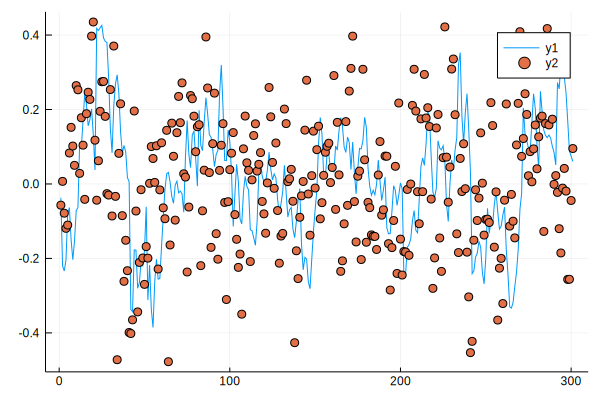

In [16]:
start = 42000
finish = 42300

plot(m_predictions[start:finish]/maximum(m_predictions))
scatter!(x_drill[start:finish]/maximum(x_drill))
#ylims!(-0.1, 0.1)

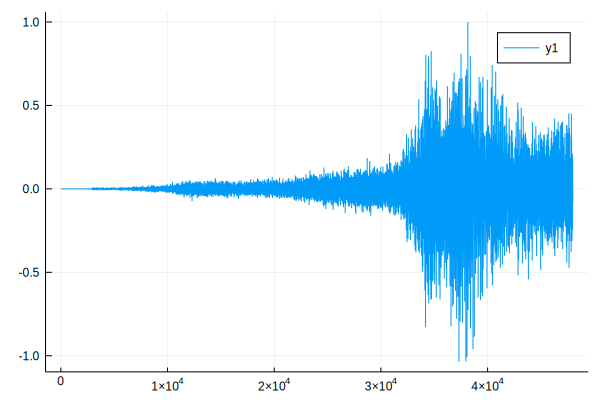

In [46]:
plot(m_predictions/maximum(m_predictions))

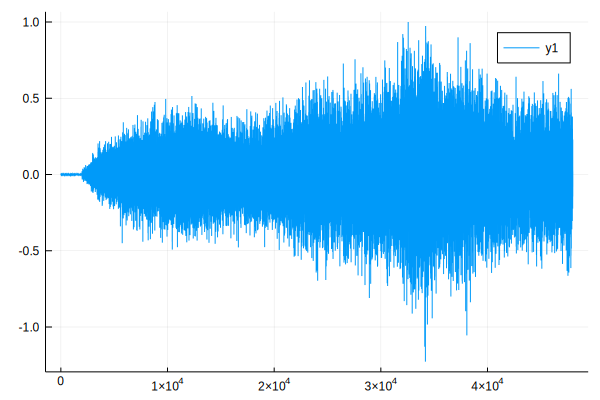

In [18]:
plot(x_drill/maximum(x_drill))

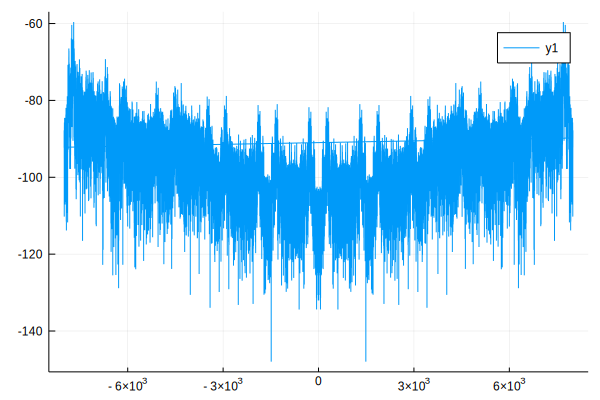

In [33]:
plot(FFTW.fftfreq(length(m_predictions), fs_desired), 20*log10.(abs.(FFTW.fftshift(FFTW.fft(m_predictions)))))

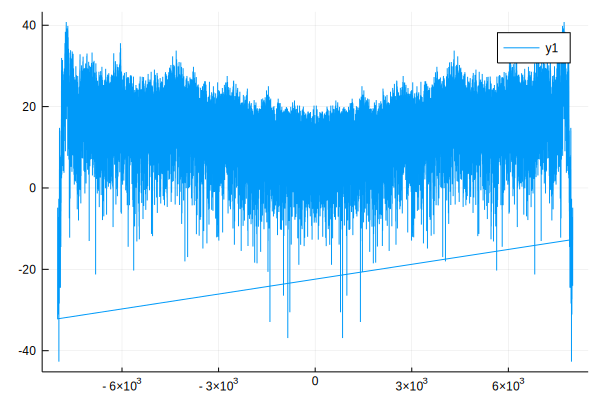

In [32]:
plot(FFTW.fftfreq(length(x_drill), fs_desired), 20*log10.(abs.(FFTW.fftshift(FFTW.fft(x_drill)))))

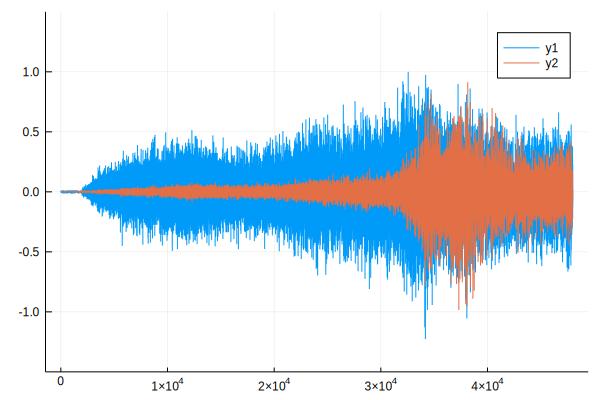

In [56]:
z = 0.1*x_drill[1:length(m_predictions)]/maximum(x_drill) + 0.9*m_predictions/maximum(m_predictions)
plot(x_drill/maximum(x_drill),ylims=(-1.5,1.5))
plot!(z)


In [57]:
audioplayers(x_drill/maximum(x_drill), 0.1*x_drill/maximum(x_drill), z, fs=fs_desired)

<source src="data:audio/wav;base64,UklGRjzuAgBXQVZFZm10ICgAAAD+/wEAgD4AAAD6AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQDuAgDpccq5zH+/ueTeFDrpiTM6sQx9OgofojqkwYw6KOuAOgKQSTpNPGM64I8oOiWFBzrT8Qs4cFSIukN7ybqRU++6+T0BuyEXGLuNIB67q18Buwrev7o4ObO64niuuvLh3bouTN26yn2JuvX6uLl5Mi05Zy6HuFCJyLhj+XK4sB73uQ0J47mBO1W6hRD1ucOY6Dg1gaw598wjOrfQVzqacOs5nmAwt60roDj6XLY5A1lhOkL7iTmilYi3RHDhObtu8TiIfCg57PA1tyGuDrmw2By61d5sutIOpboQY9+67SjRukSTdbomAE+6ShrxuRJYJbpSuQO6QfqmuRw4Obpcwwu6+VKWOIIEsjniMD867XinOhsGlTrbPDY6G0iIOsNpijrFJcw53s9aueyYBbpq2Am6iYiouIwcBLqodCa6dg1xuPZCmzl0Ryw5zgs7OT6/ojmLzIs6YtS3OvOK+TrZmO468szOOlrGkDpc9BA6Mw7BOerrKzjQ8hO6C5uFuiDooLmmmb04hslJuUh467mtwVK6apKDujs99bmvbi843fl+Oc1uSjoSxYM6yLGKOgNrWzoP4CI5aqO0NTZLn7jQ1Xg5tHSoN9VY0jgqU1i5z44pulPSFrpjWJS6BAvSuo0B4brOg7e6kbgjun5Wrjk9jpU6o1/OOiObATuciu86OipvOvBf0DligBU6x3ZRODGXZbpa34G6AzpUuqYyerp6j4+631vquhXQAbtNMt+6tpTfumuovrpIu+662fHjuudVh7ogNBW6rZoqutOaVroX6Ue6OschuUj8Hjr9QQ87k58KO1WIyjrDFjU6CfLkuK2SOzh9jDq485EJut62b7oMt+m5WYo2Ov5b7TqmYLo6ZxROOjOsXzrpsY469+jPOoggBztgxws7kdi5Oi/HfjrcRis6jAWiucjuYrpTEMu6wOnnuuWJ9LoSwMW6WZMKu+nsKrvnsQy7GxBZuhVLPTlaJZA5KYacOawDVDpuKb46qcYbO9p2YDuDC4Q7sPloO3JcTjsAPTg7akU4O2HlJztKfgg7UlqsOsyakjkE1rs5tm+bOWfg0jj9iMm51bPRuQFPX7kiX+I5YBYfOgkDijmHxZO3CiATt34pojjVbiG6vxGkun1e47rRiUm6g54cubMZGrpCCOe6t4IFu05n0LrF10G60nxYuib3sLrj2B672P0iu10fnLqobCG6H6ORuX9R7LlabUI54NXHNr/KUTkFfR46dwRXOi/LCbrN6oi6cxeDus6ZZrqfJJy6scYvuwfEY7s+LFi72vc0u0M3TLt21Fm7D9Avuxo2wLqtDYi6DtmjuUNLqLm7tVy6vmLMuXZlBDk+u7Y51KDINojIQLqIPkq6YLYXuirqjrgnSiQ600LdOr50rDq0xfU5BkZNOmwZqDrgU2U6ZqQiOkQHFjqRH+E6ow0vOz5JGzvrO+o6xuq2Ojffizot2Hs5MPUruWwbfLlJGVs5aSAAOqvNWToinks6tR+SOoIIaDr0WKM5w30oOmlzmjqjqX86MqzkOe1HmjqPuNM6FruuOqBVizqz+j06a1x9uWskqLoIIcO6xy1OupmqKLozw1a6JBKIul9vObrCyyS5I+WqNG1LJLmPWLG4W00UOqpWETqguF83311OOnol+DoIHdY6aPdJOsDaDzrK+To5XKbTOPmLDjpXO946AHUPO3B9/Dr5lIg6ICZwORgCgLhIWzm5W2mNObxwYzoq64A6rbKEOgrdrDoMFgU7FiC3OiNr0LmNvS66R8/Pupno/7q0Ik67r5qKu/f6QbvHFe66x7M4u3nrZbv82Dy7qI/IuhFQhbpBiau5h1bMOeVQejqw1FE5lS/kuYhBPjeOkPE5ROyWOqbJMzqb+go6NKFuOiKmxjp13fw6+PPFOn/nhDrqh5c6LgjaOusa6jooswA7swYXO78j1DprwdI6aD0WOy+Z1zqrFpQ6DNE4Ok7wTrihlJS6cUrluhlf/bpsrsy6C/i5usGkyrr3SoG6PzASuieUH7oyOy460k6COmLAWTqz4bw6o1YhO8RRbjvr4FY7AVVQOzcjSzvieGQ7kDY3OwkjvzqWkQE62axYOh20ITrmhz45ygDVuiN2K7uuOVa7QfiMuzqMiLuleWy7x+d4u9RqhbsCJF67IPVSu9aeUbvWpFC7ETsjuz1/2bpcNRC7FTNeuwHPTbtHDSe7mgTnuq5xwLpapJ66MA6kuG6/NzoF9tY5izqnOZs8mTqrhCc7HsYZO16M4zpimvU6BxXWOnjcqzq23s85UXaquSl3ibr+/Dm6nvNNuOf+rTnaB3c5SRYTOg3rXrmUFUC5jUChN4pZ9LYzUBy6TMIfujVzE7lrksO5pVlUOPLHbDlPC+43pFuQugAzJLq2bY659zz6NsNWhTpqvdA6JH8SO8BdbjtmIkA77ichO51BPDs61kQ72MQoOzyxXDueoFw7WzkeO/O9BjsQkb86LuO9OvQLqTqsDug5EWqFOYGe3zggD4G6+weVutrY4rnuSjm6D+XeuisfCbsiByO7PJosu6s4FLueWcW6z9Fuuiqb0DlAQIg6+G+WOktsjTpAgo46HcE5OmoYMDq8qbU5JQZHN2f+Bzou2jq3PJLmuYLafLrbAOa6AIYau8KJMruLnVS7ondmu2g9Obs2d6G62/4QugXvfrrt/hS7JTZDu3E+L7ttsdm6yd2Buk528jj37GE6UimIOkq6jjqdpXk6Br69OhpMoDrNHuM6NfMEO43xCjvqP7w6b183OtcQcTmvYDM573hqulkAM7ut+gS7TuG2uhMqvbryTOy6bH6Eun2EErqy6bG60i0eu+XpCLvEeJG6mpFVujZ5ILscUli7ey4luw7LxLowbKu6xoPJujVQm7qg35+6Yd6MuutcmbpGytC35RR6OgEArzp2ggg7bx5NO2QIPztfjyc7rYDpOlkwPTpFyMM54GwTOlmtADoruRY6kvi0OV+zEbou7f66h+3xuqwdLbpDtoq5XP+bOUFuuzoAmwc7+P3iOvk1ijq+VpE6gFA8OtM9fTq3Aqg6WxmIOlAy7zp0EQQ7UskqO7g4JjvMxRA7mqy2Op02IjoosXA6aQJWOoCGFTraQAY6SOGNOrwFiziM+A262XJ+N1AnDjrceO85wrmfMtT0xznY0ya5Q+hHuktCALrwprK49cKvOQ483rlTl5G5VV3guYqUGTcTgKo5cPaDutPVzLrzlN66nwasusi1wbogM8+6w7UXuzkSBbtQKt+6hBzXuivU27rod6O6zviXud0kOjqTVRs715lJO8IeZjvOZCk7yjAuO2WQ7zpPm4E6+9GaOpf/vTosv9o66GB+OsvYmLmNd965YTXBONW/+rkd53O69BHWuoHs+rob4ye7HYUgu/5gQbul4jO7Ku7qutRvL7rXwty6Pk0Wu/y+57pC6oi6FjkAuhpfxLlDGqE3+EZ/Otk43Do0BBU7ptciO1UqUDtd1Vs7gO9lO42IUTsoU2I76XNkO0OMTDsLhiY7ts/mOkxJtzrkVb86eANnOhYRmTqsy6c6W+M/OtYHMjpCjRA43oYauswxubpRIfK6obyLunmCPbrdhNS6hjoYuzMn9rpDS9+6RcueukKSULqqvum5nMd9uCusrrkPtJu5GEbFuXyKVLq6T326yXqAuiauiLpuJpq66Eziuia1F7vHLT27tlU9u2cPLrvhGjG7yyUbu4yZELtfJqq6pYikufOXfbcmMbu4Pwn8N/g1gzkPNIk5FMaiOlsRBDsVoiU7XFIrOyOBJTtLog07CFa0Okv/uzpZEgY6c9Q4Oqs7dzlqfNu4bxCBuss/rbqK3sO5oM5bOkigMTlrIo66Cmuquo3og7oZvL65IAe5N3kBCzt4w

In [29]:
?FFTW.fftfreq

```
fftfreq(n, fs=1)
```

Return the discrete Fourier transform (DFT) sample frequencies for a DFT of length `n`. The returned `Frequencies` object is an `AbstractVector` containing the frequency bin centers at every sample point. `fs` is the sample rate of the input signal.


In [45]:
z1_norm = FFTW.fftshift(FFTW.fft(x_drill[1:length(m_predictions)])) ./ mean(abs.(FFTW.fftshift(FFTW.fft(x_drill[1:length(m_predictions)]))))
z2_norm = FFTW.fftshift(FFTW.fft(m_predictions)) ./ mean(abs.(FFTW.fftshift(FFTW.fft(m_predictions))))
z3_norm = z1_norm - z2_norm
plot(plot(abs.(z1_norm)), plot(abs.(z2_norm)), plot(abs.(z3_norm)))

In [ ]:
using PyPlot

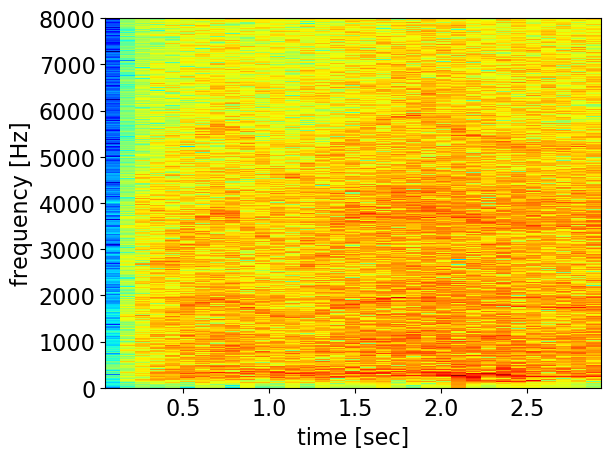

In [50]:
spec = spectrogram(x_drill, convert(Int, 100e-3*fs_desired), convert(Int, 10e-3*fs_desired), fs=fs_desired)
plot_spectrogram(spec, fs_desired);

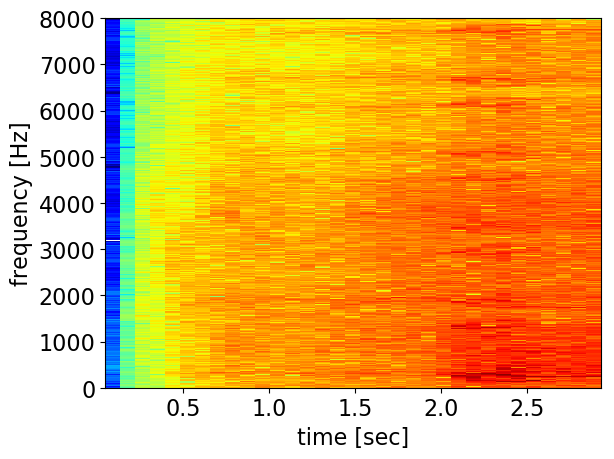

In [51]:
spec = spectrogram(m_predictions, convert(Int, 100e-3*fs_desired), convert(Int, 10e-3*fs_desired), fs=fs_desired)
plot_spectrogram(spec, fs_desired);